## Importar Librerias

In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Noticias_BCRP/notebooks")

In [0]:
import pandas as pd
import numpy as np
from sklearn import  svm , model_selection
import lightgbm as lgb
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve,auc, classification_report,confusion_matrix
import seaborn as sns
import pickle
import keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model



## Boew con k=10

In [0]:
k=10
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [9]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 3, 613538)

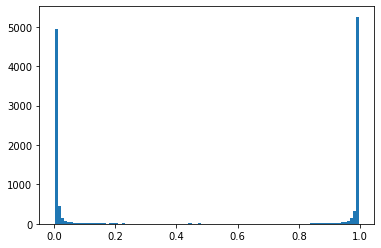

In [10]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

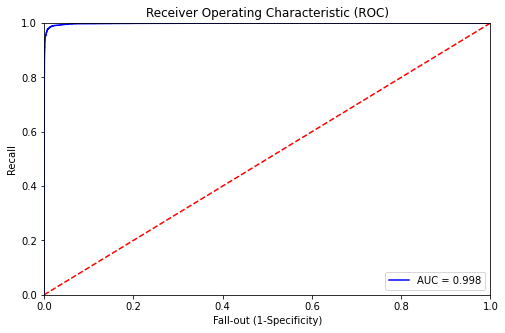

AUC score: 0.9983941518872584


In [11]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [12]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



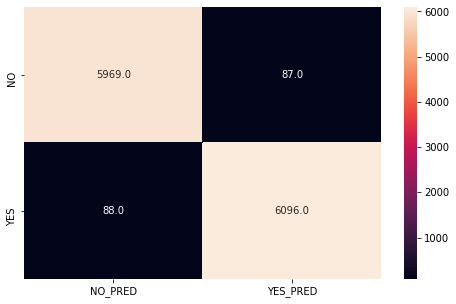

In [13]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [15]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 37, 811890)

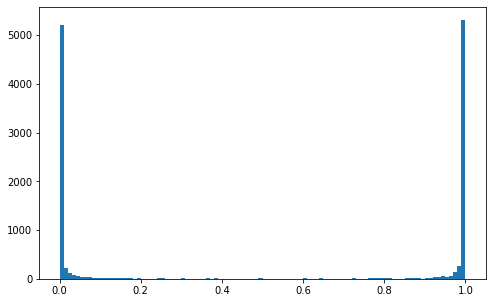

In [16]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

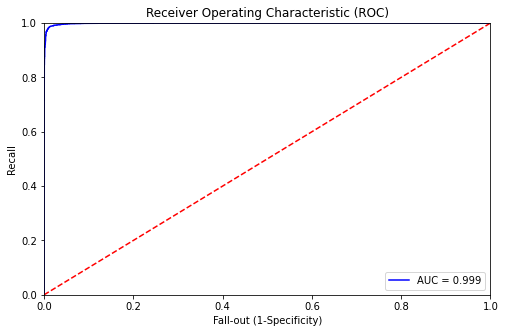

AUC score: 0.9987776467715722


In [17]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [18]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



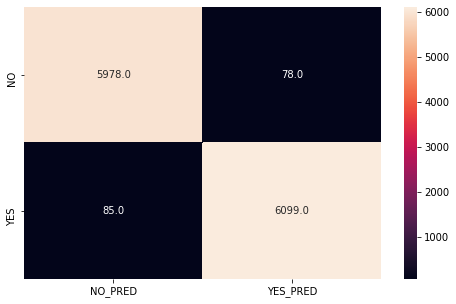

In [19]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [22]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 9s 188us/step - loss: 0.0471 - accuracy: 0.9843
Epoch 2/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0410 - accuracy: 0.9862
Epoch 3/20
48957/48957 [==============================] - 9s 181us/step - loss: 0.0406 - accuracy: 0.9861
Epoch 4/20
48957/48957 [==============================] - 9s 179us/step - loss: 0.0406 - accuracy: 0.9864
Epoch 5/20
48957/48957 [==============================] - 9s 184us/step - loss: 0.0410 - accuracy: 0.9864
Epoch 6/20
48957/48957 [==============================] - 9s 184us/step - loss: 0.0406 - accuracy: 0.9865
Epoch 7/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0405 - accuracy: 0.9866
Epoch 8/20
48957/48957 [==============================] - 9s 188us/step - loss: 0.0403 - accuracy: 0.9866
Epoch 9/20
48957/48957 [==============================] - 9s 185us/step - loss: 0.0407 - accuracy: 0.9864
Epoch 10/20
48957/48957 [=====================

datetime.timedelta(0, 184, 397684)

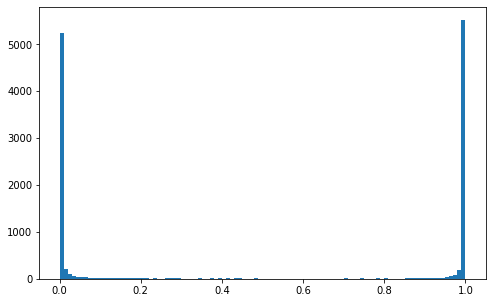

In [23]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

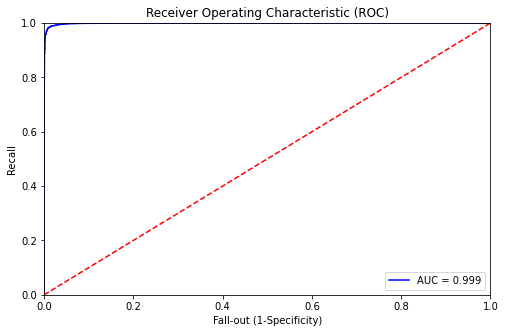

AUC score: 0.9988225596246159


In [24]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [25]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



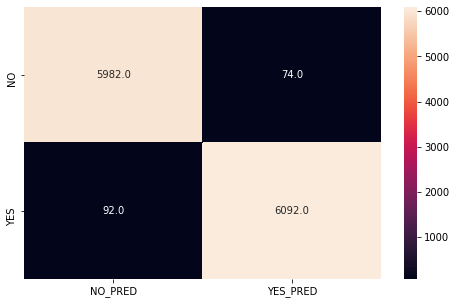

In [26]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=15

In [0]:
k=15
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [28]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 4, 431066)

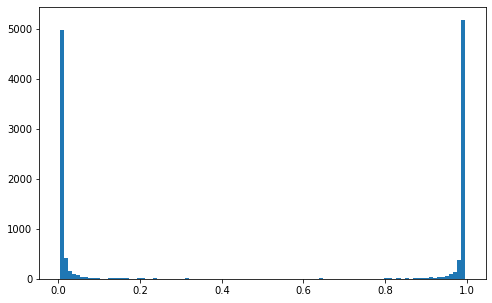

In [29]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

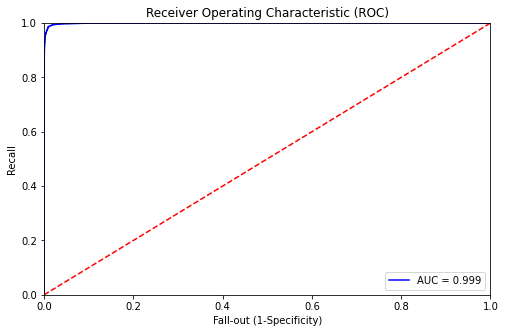

AUC score: 0.9989601018993064


In [30]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [31]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



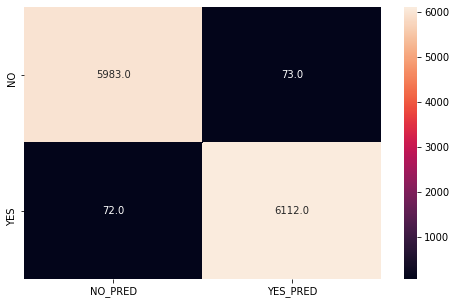

In [32]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [34]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 39, 108678)

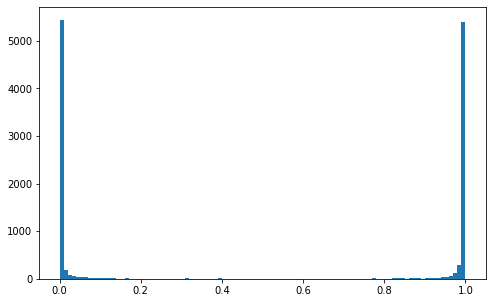

In [35]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

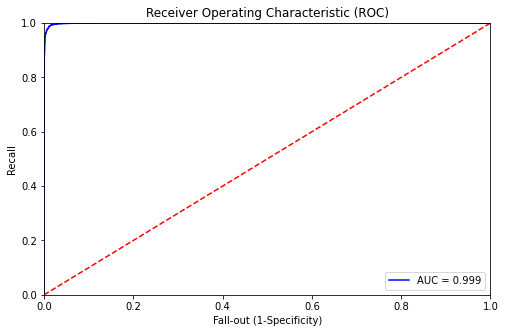

AUC score: 0.9991531844441104


In [36]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [37]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



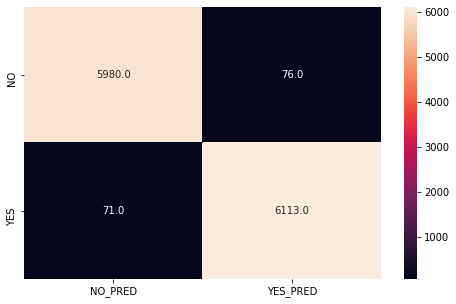

In [38]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [41]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 9s 187us/step - loss: 0.0409 - accuracy: 0.9863
Epoch 2/20
48957/48957 [==============================] - 9s 186us/step - loss: 0.0344 - accuracy: 0.9885
Epoch 3/20
48957/48957 [==============================] - 9s 187us/step - loss: 0.0337 - accuracy: 0.9885
Epoch 4/20
48957/48957 [==============================] - 9s 191us/step - loss: 0.0332 - accuracy: 0.9888
Epoch 5/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0335 - accuracy: 0.9889
Epoch 6/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0325 - accuracy: 0.9892
Epoch 7/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0329 - accuracy: 0.9891
Epoch 8/20
48957/48957 [==============================] - 9s 182us/step - loss: 0.0330 - accuracy: 0.9892
Epoch 9/20
48957/48957 [==============================] - 9s 182us/step - loss: 0.0325 - accuracy: 0.9889
Epoch 10/20
48957/48957 [=====================

datetime.timedelta(0, 181, 167600)

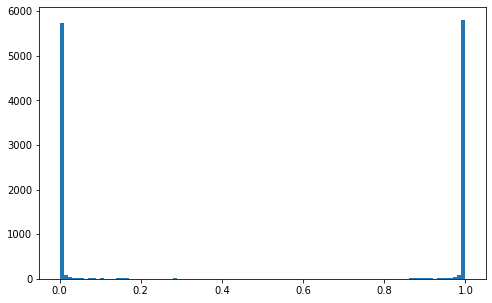

In [42]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

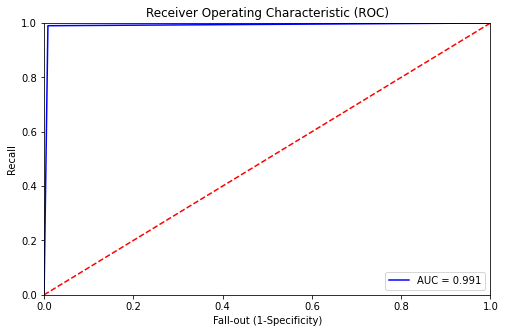

AUC score: 0.9906938005096034


In [179]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [44]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



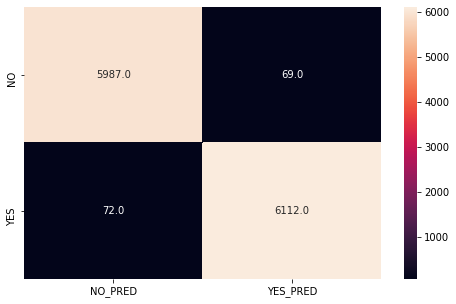

In [45]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=20

In [0]:
k=20
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [47]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 5, 118557)

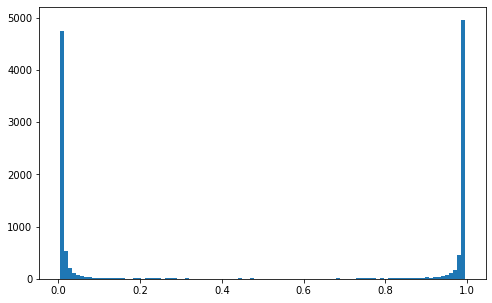

In [48]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

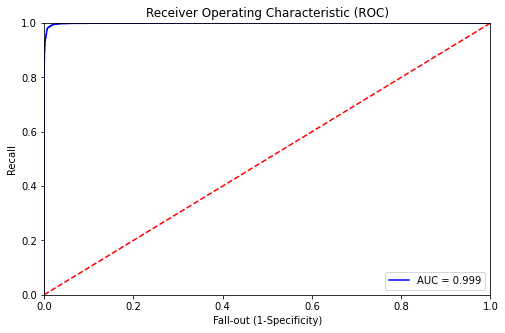

AUC score: 0.9990416366179564


In [49]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [50]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



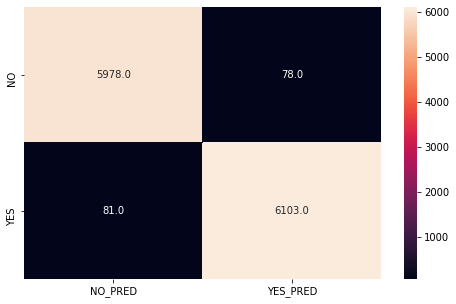

In [51]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [53]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 49, 49325)

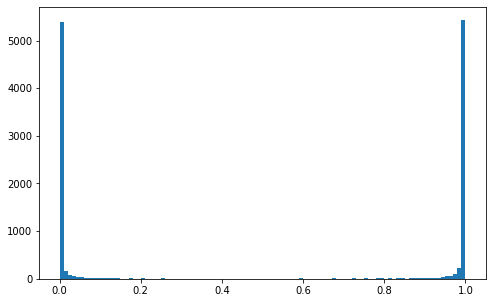

In [54]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

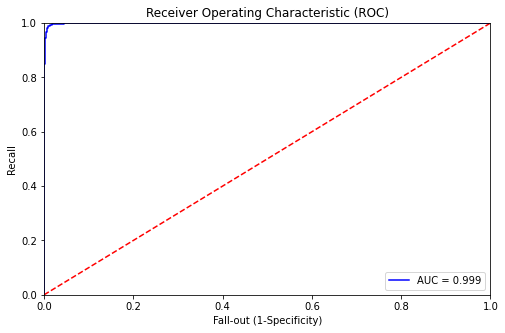

AUC score: 0.9990077784148294


In [55]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [56]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



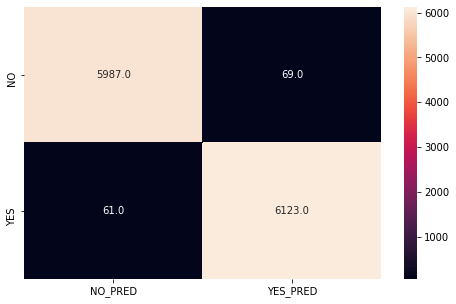

In [57]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [60]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 9s 185us/step - loss: 0.0423 - accuracy: 0.9858
Epoch 2/20
48957/48957 [==============================] - 9s 181us/step - loss: 0.0357 - accuracy: 0.9887
Epoch 3/20
48957/48957 [==============================] - 9s 181us/step - loss: 0.0344 - accuracy: 0.9889
Epoch 4/20
48957/48957 [==============================] - 9s 182us/step - loss: 0.0333 - accuracy: 0.9895
Epoch 5/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0341 - accuracy: 0.9893
Epoch 6/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0332 - accuracy: 0.9894
Epoch 7/20
48957/48957 [==============================] - 9s 182us/step - loss: 0.0333 - accuracy: 0.9895
Epoch 8/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0333 - accuracy: 0.9898
Epoch 9/20
48957/48957 [==============================] - 9s 180us/step - loss: 0.0330 - accuracy: 0.9900
Epoch 10/20
48957/48957 [=====================

datetime.timedelta(0, 180, 484751)

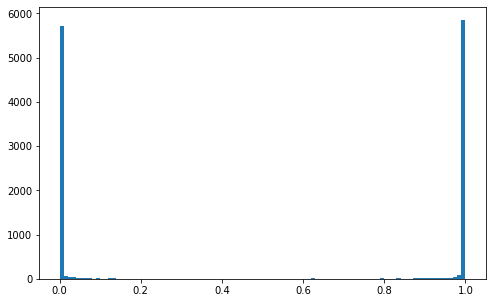

In [61]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

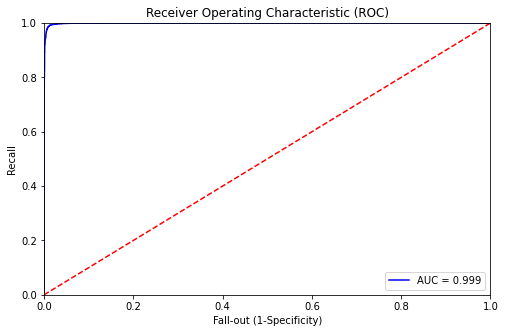

AUC score: 0.9990148277568054


In [62]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [63]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



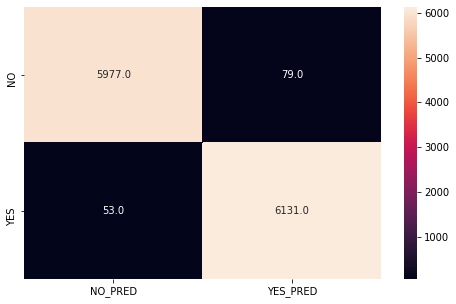

In [64]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=25

In [0]:
k=25
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [66]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 5, 817010)

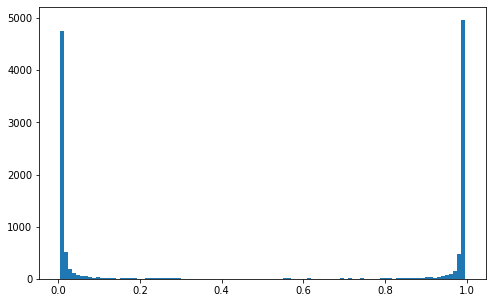

In [67]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

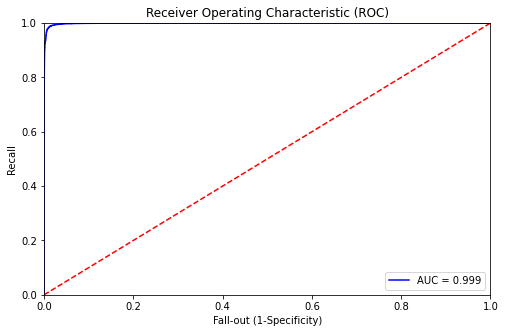

AUC score: 0.9989326121358053


In [68]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [69]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



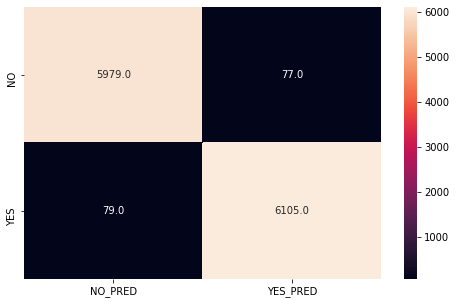

In [70]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [72]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 53, 274536)

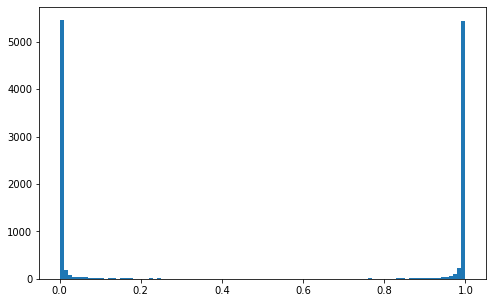

In [73]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

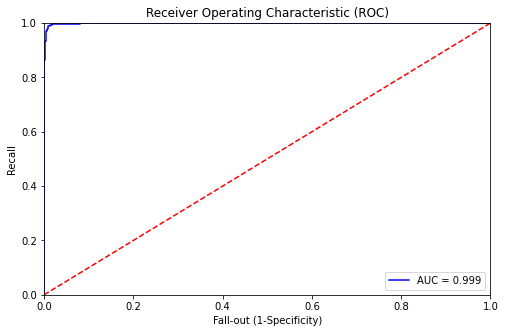

AUC score: 0.9988991811655253


In [74]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [75]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



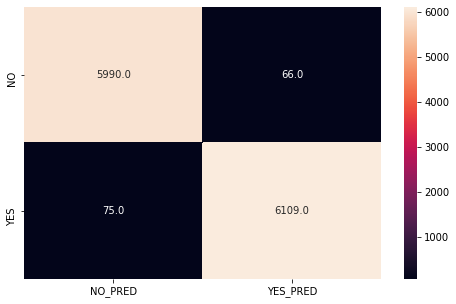

In [76]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [79]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 13s 258us/step - loss: 0.0408 - accuracy: 0.9868
Epoch 2/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0332 - accuracy: 0.9892
Epoch 3/20
48957/48957 [==============================] - 9s 188us/step - loss: 0.0322 - accuracy: 0.9899
Epoch 4/20
48957/48957 [==============================] - 9s 182us/step - loss: 0.0318 - accuracy: 0.9902
Epoch 5/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0314 - accuracy: 0.9903
Epoch 6/20
48957/48957 [==============================] - 9s 182us/step - loss: 0.0304 - accuracy: 0.9904
Epoch 7/20
48957/48957 [==============================] - 9s 181us/step - loss: 0.0299 - accuracy: 0.9908
Epoch 8/20
48957/48957 [==============================] - 9s 182us/step - loss: 0.0296 - accuracy: 0.9906
Epoch 9/20
48957/48957 [==============================] - 9s 180us/step - loss: 0.0299 - accuracy: 0.9911
Epoch 10/20
48957/48957 [====================

datetime.timedelta(0, 183, 725133)

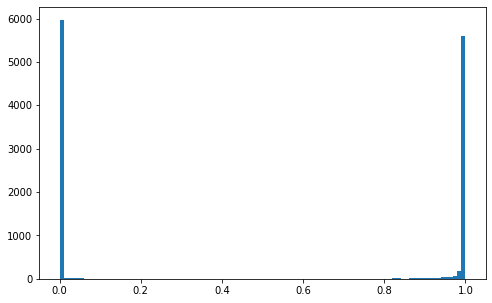

In [80]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

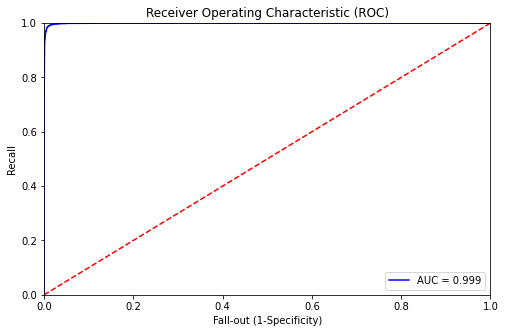

AUC score: 0.9992124897036884


In [81]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [82]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



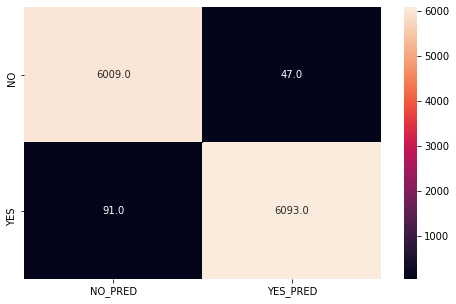

In [83]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=30

In [0]:
k=30
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [85]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 6, 229581)

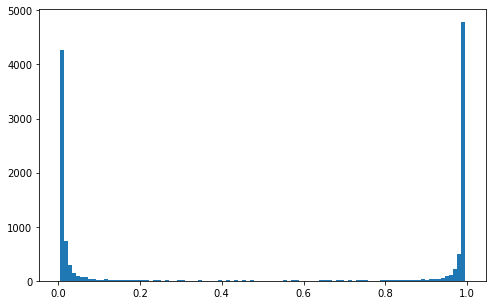

In [86]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

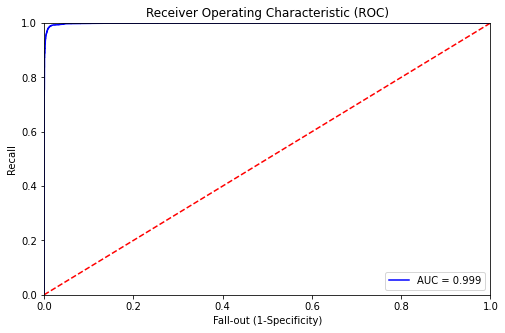

AUC score: 0.9987984877238913


In [87]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [88]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



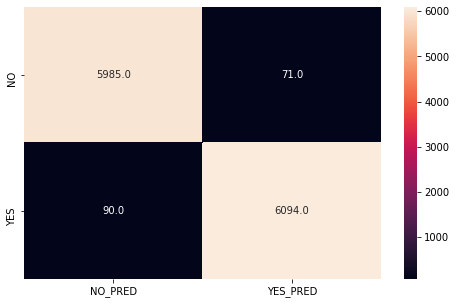

In [89]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [91]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 64, 787256)

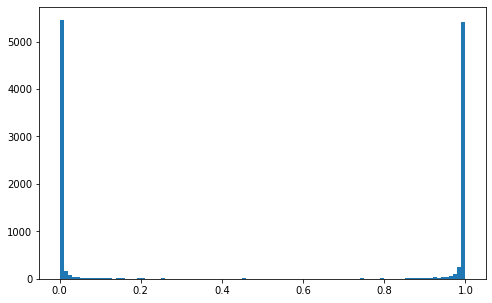

In [92]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

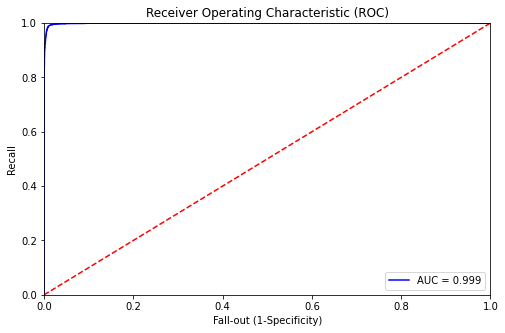

AUC score: 0.99893297261352


In [93]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [94]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



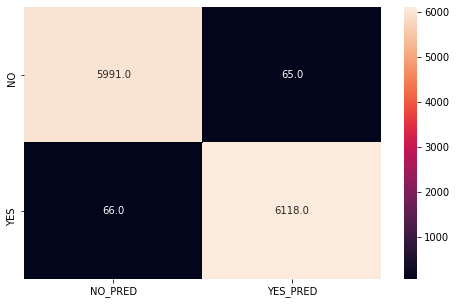

In [95]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [98]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0399 - accuracy: 0.9868
Epoch 2/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0327 - accuracy: 0.9899
Epoch 3/20
48957/48957 [==============================] - 9s 185us/step - loss: 0.0314 - accuracy: 0.9903
Epoch 4/20
48957/48957 [==============================] - 9s 184us/step - loss: 0.0313 - accuracy: 0.9907
Epoch 5/20
48957/48957 [==============================] - 9s 185us/step - loss: 0.0308 - accuracy: 0.9907
Epoch 6/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0289 - accuracy: 0.9911
Epoch 7/20
48957/48957 [==============================] - 9s 184us/step - loss: 0.0284 - accuracy: 0.9913
Epoch 8/20
48957/48957 [==============================] - 9s 186us/step - loss: 0.0272 - accuracy: 0.9915
Epoch 9/20
48957/48957 [==============================] - 9s 187us/step - loss: 0.0277 - accuracy: 0.9917
Epoch 10/20
48957/48957 [=====================

datetime.timedelta(0, 181, 61123)

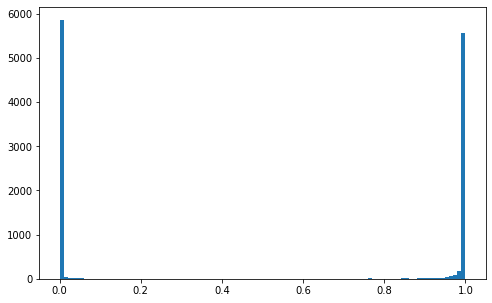

In [99]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

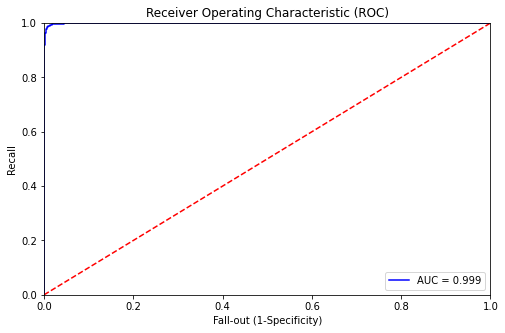

AUC score: 0.9992487911446594


In [100]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [101]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



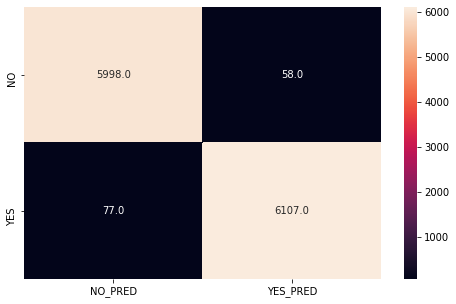

In [102]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=35

In [0]:
k=35
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [104]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 7, 95704)

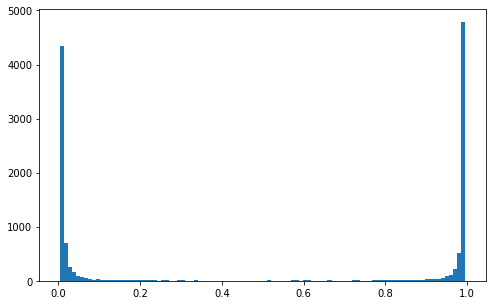

In [105]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

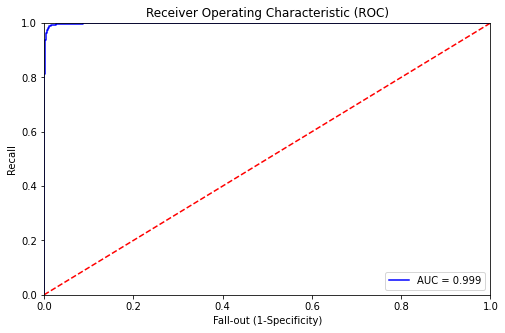

AUC score: 0.9986729346709708


In [106]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [107]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



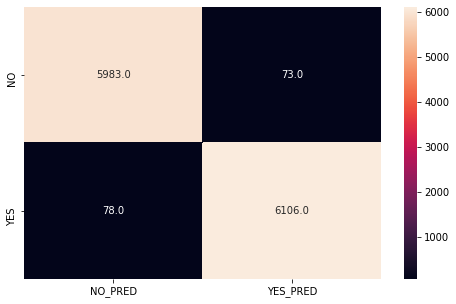

In [108]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [110]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 76, 237244)

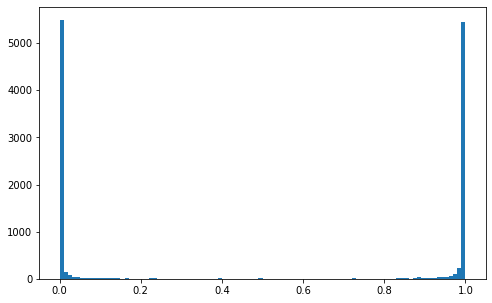

In [111]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

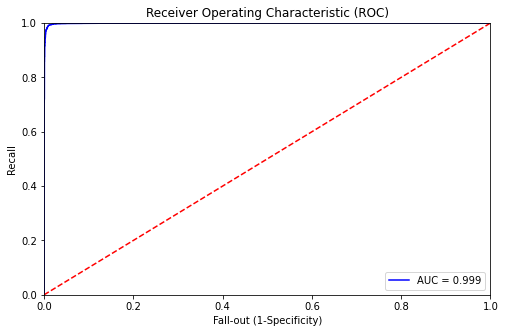

AUC score: 0.9990113297878703


In [112]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [113]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



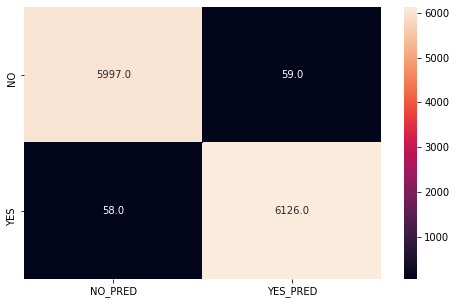

In [114]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [117]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 10s 196us/step - loss: 0.0392 - accuracy: 0.9871
Epoch 2/20
48957/48957 [==============================] - 9s 188us/step - loss: 0.0308 - accuracy: 0.9900
Epoch 3/20
48957/48957 [==============================] - 9s 189us/step - loss: 0.0301 - accuracy: 0.9909
Epoch 4/20
48957/48957 [==============================] - 9s 191us/step - loss: 0.0286 - accuracy: 0.9915
Epoch 5/20
48957/48957 [==============================] - 9s 191us/step - loss: 0.0281 - accuracy: 0.9916
Epoch 6/20
48957/48957 [==============================] - 9s 188us/step - loss: 0.0271 - accuracy: 0.9919
Epoch 7/20
48957/48957 [==============================] - 9s 189us/step - loss: 0.0259 - accuracy: 0.9924
Epoch 8/20
48957/48957 [==============================] - 9s 192us/step - loss: 0.0261 - accuracy: 0.9924
Epoch 9/20
48957/48957 [==============================] - 13s 266us/step - loss: 0.0266 - accuracy: 0.9926
Epoch 10/20
48957/48957 [===================

datetime.timedelta(0, 189, 839321)

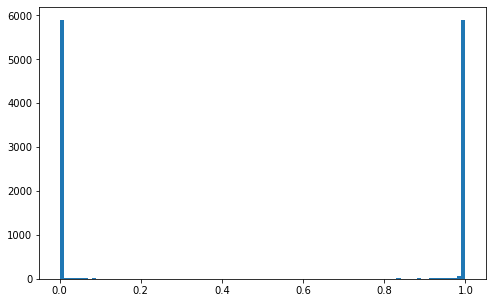

In [118]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

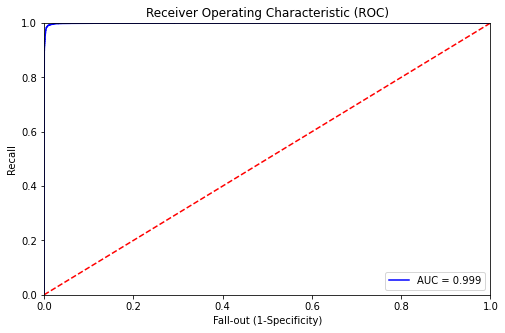

AUC score: 0.9992527296974679


In [119]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [120]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



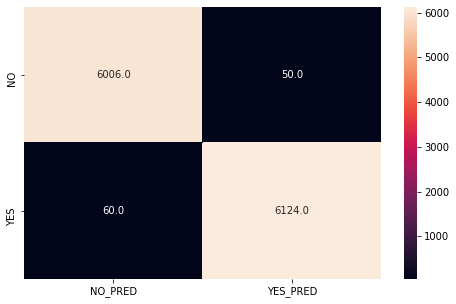

In [121]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=40

In [0]:
k=40
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [123]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 7, 812815)

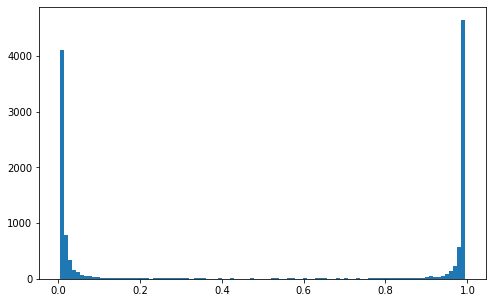

In [124]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

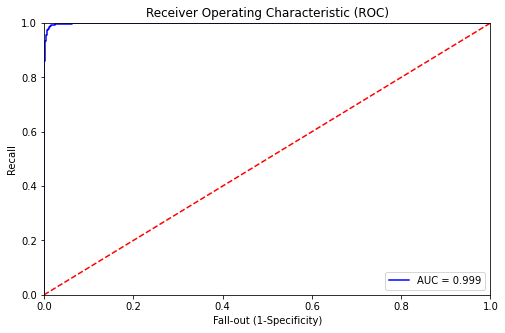

AUC score: 0.9987775533143869


In [125]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [126]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



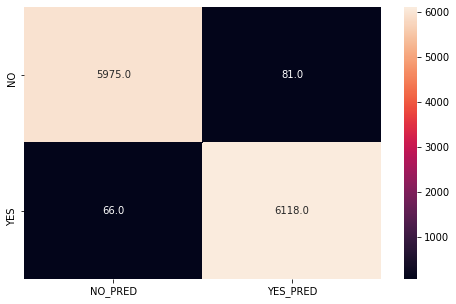

In [127]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [129]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 89, 855708)

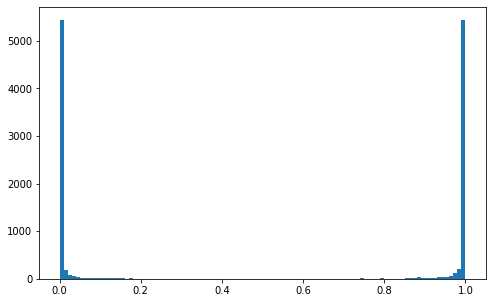

In [130]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

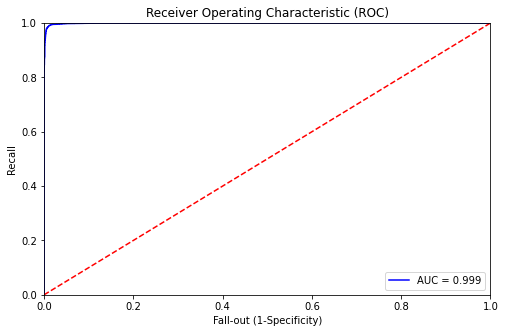

AUC score: 0.9991089791954693


In [131]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [132]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



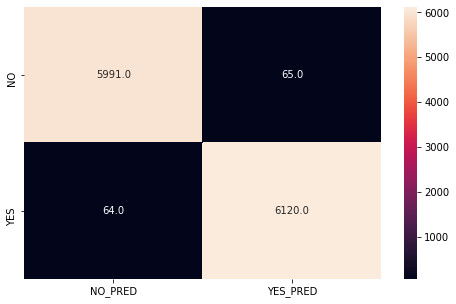

In [133]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [136]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 9s 189us/step - loss: 0.0373 - accuracy: 0.9879
Epoch 2/20
48957/48957 [==============================] - 9s 185us/step - loss: 0.0294 - accuracy: 0.9907
Epoch 3/20
48957/48957 [==============================] - 9s 184us/step - loss: 0.0284 - accuracy: 0.9912
Epoch 4/20
48957/48957 [==============================] - 9s 184us/step - loss: 0.0269 - accuracy: 0.9917
Epoch 5/20
48957/48957 [==============================] - 9s 183us/step - loss: 0.0263 - accuracy: 0.9918
Epoch 6/20
48957/48957 [==============================] - 9s 186us/step - loss: 0.0258 - accuracy: 0.9923
Epoch 7/20
48957/48957 [==============================] - 9s 187us/step - loss: 0.0255 - accuracy: 0.9924
Epoch 8/20
48957/48957 [==============================] - 9s 188us/step - loss: 0.0250 - accuracy: 0.9927
Epoch 9/20
48957/48957 [==============================] - 9s 186us/step - loss: 0.0245 - accuracy: 0.9931
Epoch 10/20
48957/48957 [=====================

datetime.timedelta(0, 183, 2128)

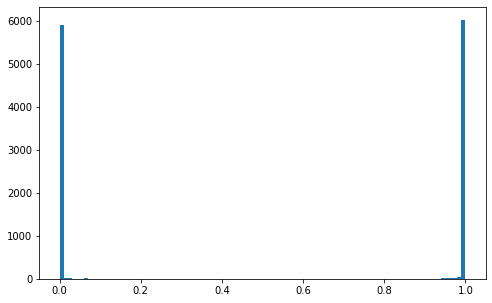

In [137]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

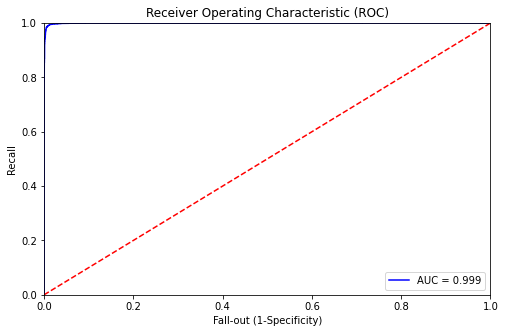

AUC score: 0.9993044115209319


In [138]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [139]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



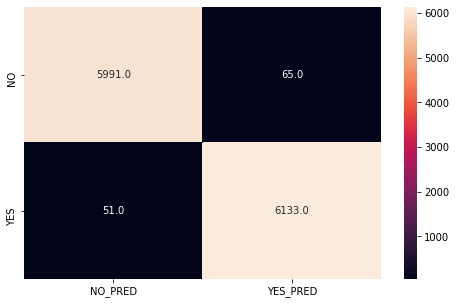

In [140]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=45

In [0]:
k=45
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [142]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 8, 712303)

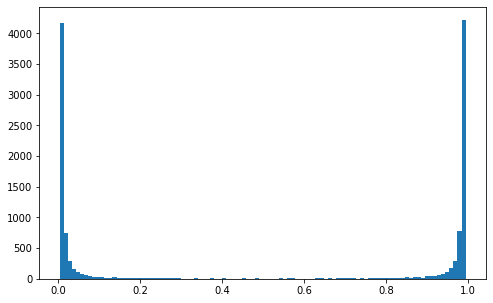

In [143]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

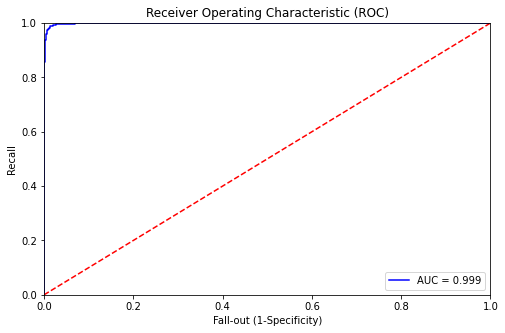

AUC score: 0.9988887406628262


In [144]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [145]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



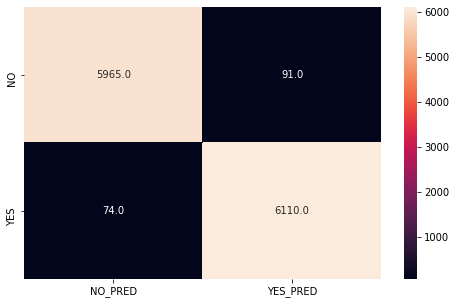

In [146]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [148]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 97, 746945)

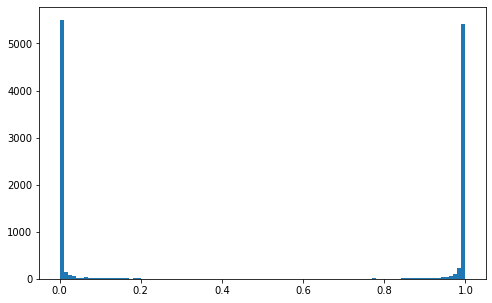

In [149]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

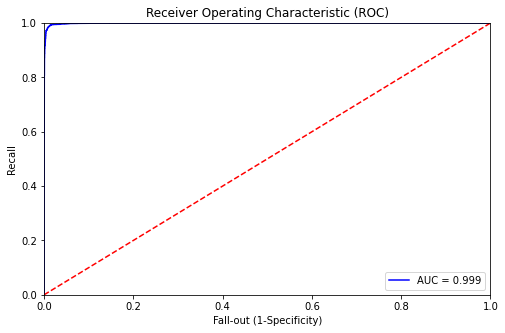

AUC score: 0.9990264698518869


In [150]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [151]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



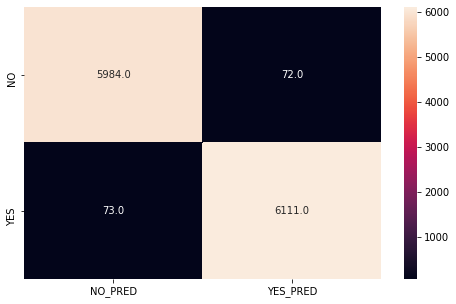

In [152]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [155]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 10s 196us/step - loss: 0.0396 - accuracy: 0.9871
Epoch 2/20
48957/48957 [==============================] - 10s 196us/step - loss: 0.0297 - accuracy: 0.9908
Epoch 3/20
48957/48957 [==============================] - 9s 194us/step - loss: 0.0281 - accuracy: 0.9915
Epoch 4/20
48957/48957 [==============================] - 9s 193us/step - loss: 0.0269 - accuracy: 0.9921
Epoch 5/20
48957/48957 [==============================] - 10s 195us/step - loss: 0.0264 - accuracy: 0.9920
Epoch 6/20
48957/48957 [==============================] - 9s 192us/step - loss: 0.0251 - accuracy: 0.9924
Epoch 7/20
48957/48957 [==============================] - 9s 190us/step - loss: 0.0244 - accuracy: 0.9928
Epoch 8/20
48957/48957 [==============================] - 10s 195us/step - loss: 0.0239 - accuracy: 0.9930
Epoch 9/20
48957/48957 [==============================] - 10s 194us/step - loss: 0.0232 - accuracy: 0.9932
Epoch 10/20
48957/48957 [================

datetime.timedelta(0, 193, 469537)

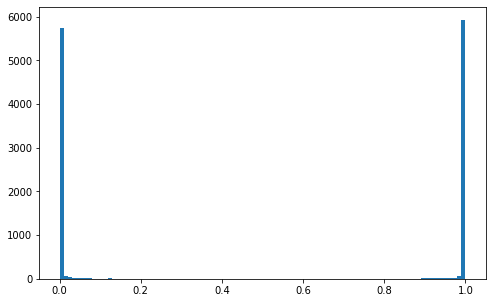

In [156]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

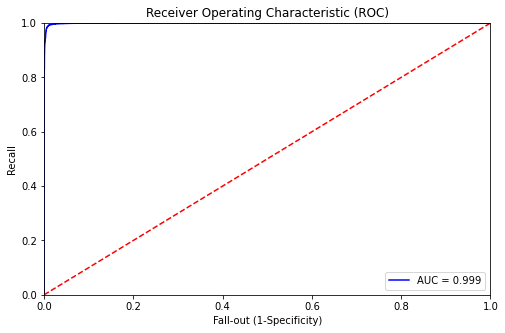

AUC score: 0.9991983776687098


In [157]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [158]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



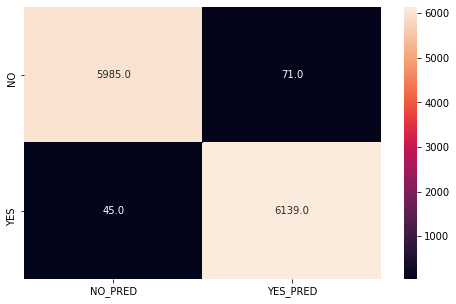

In [159]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Boew con k=50

In [0]:
k=50
### guardar los modelos
# modelo=pickle.load(open("../models/boew/modelo.pkl","rb"))
# scaler_kmeans=pickle.load(open("../models/boew/scaler_kmeans_{}.pkl".format(k),"rb"))
# kmeans_model=pickle.load(open("../models/boew/kmeans_model_{}.pkl".format(k),"rb"))
# scaler_boew=pickle.load(open("../models/boew/scaler_boew_{}.pkl".format(k),"rb"))
### Guarda la vectorizacion word2vec
boew_train=np.load("../data/preprocessed/boew/boew_train_{}.npy".format(k))
boew_test=np.load("../data/preprocessed/boew/boew_test_{}.npy".format(k))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [161]:
train_data=lgb.Dataset(boew_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 8, 905512)

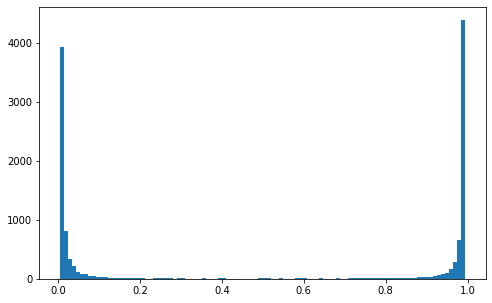

In [162]:
pred_lg=lg_model.predict(boew_test)
plt.hist(pred_lg,bins=100)
plt.show()

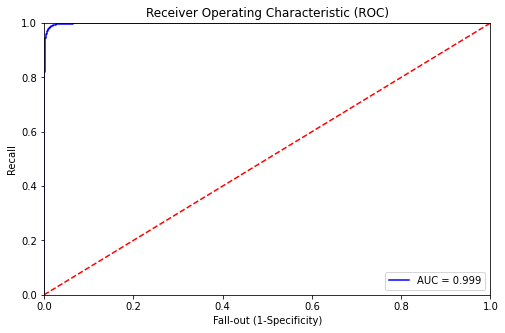

AUC score: 0.9987641488838114


In [163]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [164]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6056
           1       0.98      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



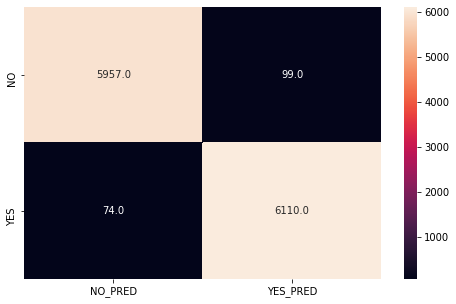

In [165]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [0]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [167]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(boew_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 111, 725364)

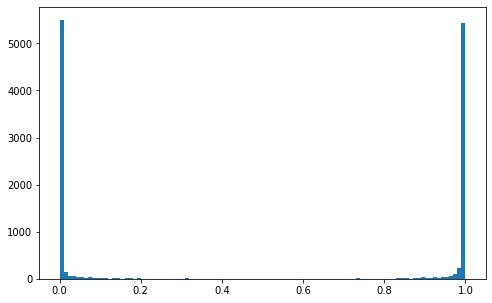

In [168]:
pred_svm = svm_model.predict_proba(boew_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

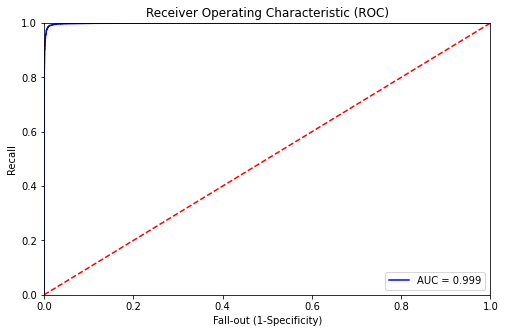

AUC score: 0.9988841479097206


In [169]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [170]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



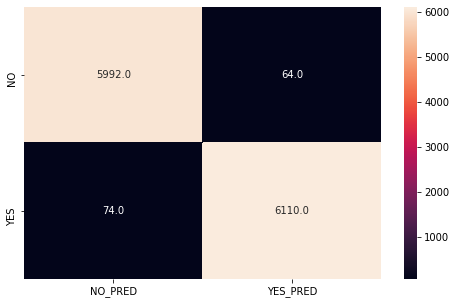

In [171]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [0]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [0]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(boew_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [174]:
start=datetime.now()
model_rnn.fit(boew_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 10s 195us/step - loss: 0.0385 - accuracy: 0.9874
Epoch 2/20
48957/48957 [==============================] - 9s 192us/step - loss: 0.0294 - accuracy: 0.9908
Epoch 3/20
48957/48957 [==============================] - 9s 190us/step - loss: 0.0278 - accuracy: 0.9919
Epoch 4/20
48957/48957 [==============================] - 9s 190us/step - loss: 0.0264 - accuracy: 0.9920
Epoch 5/20
48957/48957 [==============================] - 9s 190us/step - loss: 0.0255 - accuracy: 0.9924
Epoch 6/20
48957/48957 [==============================] - 9s 193us/step - loss: 0.0237 - accuracy: 0.9930
Epoch 7/20
48957/48957 [==============================] - 9s 193us/step - loss: 0.0225 - accuracy: 0.9929
Epoch 8/20
48957/48957 [==============================] - 9s 189us/step - loss: 0.0223 - accuracy: 0.9937
Epoch 9/20
48957/48957 [==============================] - 9s 185us/step - loss: 0.0214 - accuracy: 0.9939
Epoch 10/20
48957/48957 [====================

datetime.timedelta(0, 186, 416408)

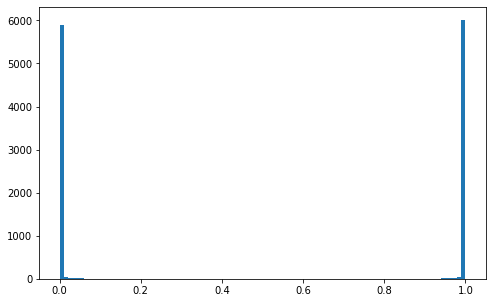

In [175]:
pred_rnn=model_rnn.predict_proba(boew_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

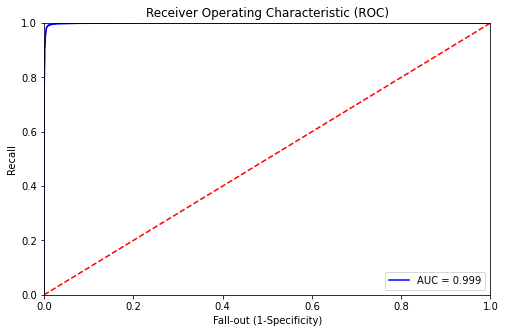

AUC score: 0.9990529983414821


In [176]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [177]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



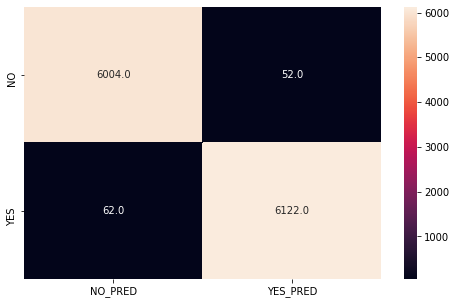

In [178]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()